## NET Notebook 

Notebook for training the single models with U-Net architecture, based on the parameters that are specified in script_settings.py. The models are trained on 90% of the training data, with random seed 42. 

**Dataset Description**

The dataset used for this baseline is OCT images released in GOALS. The input data provided in the project is for baseline operation only and is not a complete challenge dataset. Users can obtain the corresponding datasets by signing up for the GOALS challenge.


In [1]:
### import the necessary packages

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torchmetrics.classification import Dice
import imgaug.augmenters as iaa
from einops import rearrange, repeat
from torch import Tensor
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from utils.networks import get_model
from utils.utils import load_model, mask_input, EarlyStopper
from utils.data import OCTDataset
from utils.losses import DiceLoss
from utils.metrics import weighted_dice_score, dice_coeff
from script_settings import COLAB, IMAGE_SIZE, TRAIN_AUGMENT, VAL_AUGMENT, AUGMENT_STRING, VAL_RATIO, BATCH_SIZE, INIT_LR, EPOCHS, MODEL_NAME, OUT_CHANNELS, BLOCK_NUM, MLP_DIM, WEIGHTED, MARGIN_MASK, DROPOUT_PROB, SKIP_PROB, LOAD, DICE_OPTIMIZATION, SCHEDULER_PATIENCE, SCHEDULER_FACTOR

c:\Users\HP Omen Test\Documents\Max\AI4MI_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\HP Omen Test\Documents\Max\AI4MI_env\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "mps"
device = torch.device(DEVICE)

print("Using device:", device)

if COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive", force_remount=True)

MODELS_PATH = "/content/gdrive/MyDrive/AI4MI/work/models/" if COLAB else "models/"

Using device: cuda:0


In [3]:
### set the parameters in your framework
train_images_folder = (
    "/content/gdrive/MyDrive/AI4MI/train/Image" if COLAB else "data/train/Image"
)  # the path to the training data
val_images_folder = (
    "/content/gdrive/MyDrive/AI4MI/val/Image" if COLAB else "data/val/Image"
)  # the path to the validation data

# As long as we don't have the test labels, we will use the validation set as test set
test_images_folder = val_images_folder

gt_folder = (
    "/content/gdrive/MyDrive/AI4MI/train/Layer_Masks/"
    if COLAB
    else "data/train/Layer_masks/"
)

In [4]:

# divide the training image and the verification image from the training set
filelists = os.listdir(train_images_folder)
train_filelists, val_filelists = train_test_split(filelists, test_size=VAL_RATIO, random_state=42)
print(
    "Total Nums: {}, train: {}, val: {}".format(
        len(filelists), len(train_filelists), len(val_filelists)
    )
)

Total Nums: 100, train: 90, val: 10


In [5]:
training_data = OCTDataset(
    image_file=train_images_folder,
    gt_path=gt_folder,
    filelists=train_filelists,
    mode="train",
    image_size=IMAGE_SIZE,
)

val_data = OCTDataset(
    image_file=train_images_folder,  # val_images_folder - Not used until we have the masks of the validation data
    gt_path=gt_folder,
    filelists=val_filelists,
    mode="train",
    image_size=IMAGE_SIZE,
)

train_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

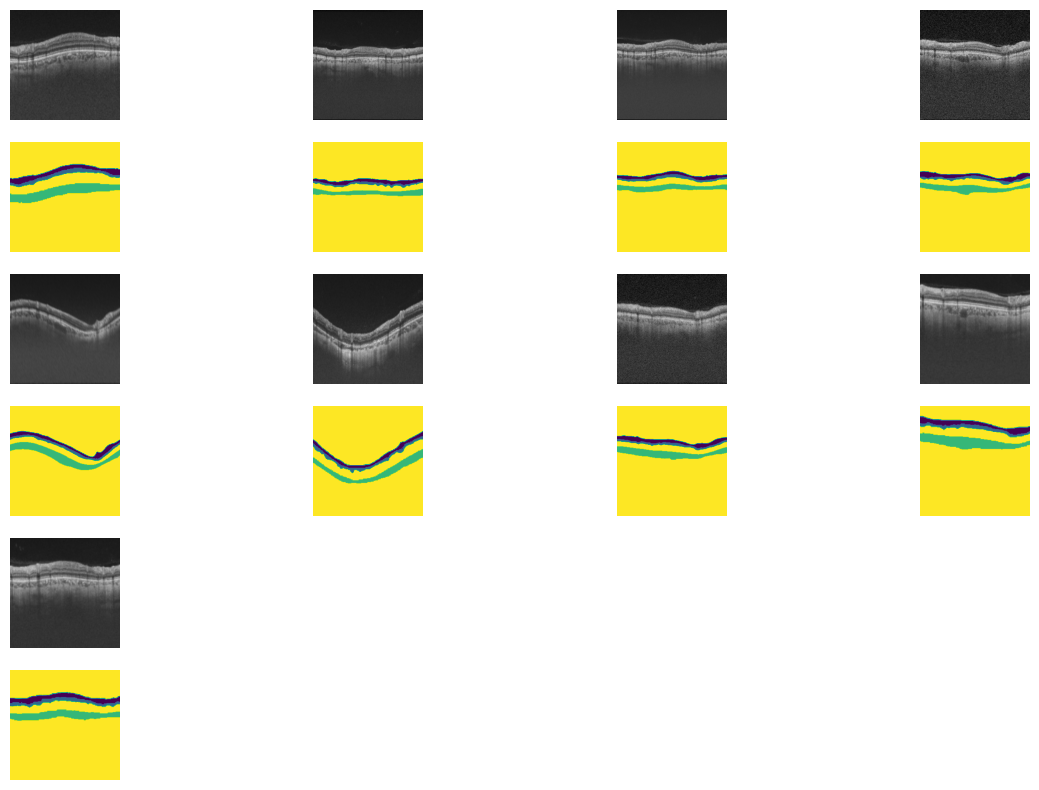

In [6]:
## Data Augmentation

# Augmenters definition
random_crop = iaa.Crop(percent=(0.1, 0.25))
det_crop = iaa.Crop(percent=(0.15))
mirror_only = iaa.Fliplr(1.0)
random_blur = iaa.GaussianBlur(sigma=(0.15, 0.5))
random_noise = iaa.AdditiveGaussianNoise(scale=(5, 15))
motion_blur = iaa.MotionBlur(k=5, angle=[-20, 20])
rotate = iaa.Affine(rotate=(-5, 5))
shear = iaa.Affine(shear=(-5, 5))

# Define combinations
crop_and_mirror = iaa.Sequential([random_crop, mirror_only])
motion_and_noise = iaa.Sequential([motion_blur, random_noise])
crop_and_rotate = iaa.Sequential([rotate, det_crop])
crop_and_shear = iaa.Sequential([shear, det_crop])
crop_rotate_mirror = iaa.Sequential([rotate, det_crop, mirror_only])
crop_shear_mirrror = iaa.Sequential([shear, det_crop, mirror_only])

# List of augmenters and their names
augmenters = [
    (random_crop, "random_crop"),
    (mirror_only, "mirror_only"),
    (random_blur, "random_blur"),
    (random_noise, "random_noise"),
    (motion_blur, "motion_blur"),
    (crop_and_mirror, "crop_and_mirror"),
    (motion_and_noise, "motion_and_noise"),
    (crop_and_rotate, "crop_and_rotate"),
    (crop_and_shear, "crop_and_shear"),
]

# Combine augmented datasets to one super set
TrainAugDataset = training_data
ValAugDataset = val_data

plt.figure(figsize=(15, 10))
for i, (aug, name) in enumerate(augmenters):
    train_augmented = OCTDataset(
        image_file=train_images_folder,
        gt_path=gt_folder,
        filelists=train_filelists,
        augmenter=aug,
        aug_name=name,
    )
    val_augmented = OCTDataset(
        image_file=train_images_folder,
        gt_path=gt_folder,
        filelists=val_filelists,
        augmenter=aug,
        aug_name=name,
    )
    img, label = train_augmented.__getitem__(i)
    if i < 4:
        plt.subplot(6, 4, i + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis("off")

        plt.subplot(6, 4, i + 5)
        plt.imshow(label)
        plt.axis("off")
    elif i >= 4 and i < 8:
        plt.subplot(6, 4, i + 5)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis("off")

        plt.subplot(6, 4, i + 9)
        plt.imshow(label)
        plt.axis("off")

    else:
        plt.subplot(6, 4, i + 9)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis("off")

        plt.subplot(6, 4, i + 13)
        plt.imshow(label)
        plt.axis("off")

    TrainAugDataset = ConcatDataset([TrainAugDataset, train_augmented])
    ValAugDataset = ConcatDataset([ValAugDataset, val_augmented])

aug_train_loader = DataLoader(TrainAugDataset, batch_size=BATCH_SIZE, shuffle=True)
aug_val_loader = DataLoader(ValAugDataset, batch_size=BATCH_SIZE, shuffle=True)

**Training Loop**


In [7]:
# Training Loop
model = get_model(
    MODEL_NAME, in_channels=3, num_classes=4, out_channels=OUT_CHANNELS, mlp_dim=MLP_DIM, block_num=BLOCK_NUM, dropout_prob=DROPOUT_PROB, skip_prob=SKIP_PROB
).to(device)

# Criterion - Class Weights
if WEIGHTED:
    weights = torch.tensor([1.8, 2, 1.5, 0.9]).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
else:
    criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=INIT_LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE, verbose=True
)

# Early stopping class
early_stopper = EarlyStopper(patience=40, min_delta=0.05, verbose=True)

# Initial load
best_model_params_path = os.path.join(
    MODELS_PATH, f"{model.__class__.__name__}{AUGMENT_STRING}_best_params.pt"
)

if LOAD:
    model = load_model(model, best_model_params_path).to(device)

best_dice = 100

for e in tqdm(range(EPOCHS), total=EPOCHS):
    for mode in ["train", "eval"]:
        # Chosse DataLoader
        train_loader = aug_train_loader if TRAIN_AUGMENT else train_loader
        val_loader = aug_val_loader if VAL_AUGMENT else val_loader
        dataloader = train_loader if mode == "train" else val_loader

        model.train() if mode == "train" else model.eval()

        running_loss = 0
        running_dice = 0
        running_torch = 0
        running_weight_dice = 0

        weighted_list = []
        for i, data in enumerate(dataloader):

            # Every data instance is an input + label pair
            inputs, masks_true = data
            inputs = (inputs / 255.0).to(torch.float32).to(device)
            masks_true = masks_true.to(torch.int64).to(device)

            # Zero your gradients for every batch!
            optimizer.zero_grad()

            # Make predictions for this batch
            masks_pred = model(inputs)
            
            weighted_dice = 1 - weighted_dice_score(
                F.softmax(masks_pred, dim=1).float(), # if not needed for optimization: F.one_hot(torch.argmax(masks_pred, dim=1), model.num_classes).permute(0, 3, 1, 2),
                F.one_hot(masks_true, model.num_classes).permute(0, 3, 1, 2).float(),
                class_weights = weights if WEIGHTED else None
            ) # 0 = batch, 3 = one_hot, 1 = img_h, 2 = img_w
            weighted_list.append(weighted_dice.tolist())

            # Compute the loss - Cross Entropy loss and DICE loss
            # Weights for CE loss
            loss = criterion(masks_pred, masks_true)

            dice_loss = 1 - dice_coeff(
                F.softmax(masks_pred, dim=1), # if not needed for optimization: F.one_hot(torch.argmax(masks_pred, dim=1), model.num_classes).permute(0, 3, 1, 2),
                F.one_hot(masks_true, model.num_classes).permute(0, 3, 1, 2),
            )  # 0 = batch, 3 = one_hot, 1 = img_h, 2 = img_w

            torch_dice = Dice().to(device)
            torch_dice_score = torch_dice(masks_pred, masks_true)
            torch_loss = 1 - torch_dice_score

            if MARGIN_MASK: # Weight loss of margin pixels higher
                masked_masks_true = mask_input(masks_true, 40, 40)
                masked_masks_pred = mask_input(masks_pred, 40, 40)
                margin_loss = criterion(masked_masks_pred, masked_masks_true)
                loss = loss + margin_loss * 0.5

            # Loss calculation
            running_loss += loss.item() * inputs.size(0)
            running_dice += dice_loss.item() / inputs.size(0)
            running_torch += torch_loss.item() * inputs.size(0)
            running_weight_dice += weighted_dice.mean().item() #Average over single layers

            if mode == "train":
                # Compute the gradients
                if DICE_OPTIMIZATION:
                    if WEIGHTED:
                        combined_dice = dice_loss + weighted_dice.mean().item()
                        combined_dice.backward()
                    else:
                        dice_loss.backward()
                else:
                    loss.backward()

                # Adjust weights
                optimizer.step()

        epoch_loss = running_loss / len(dataloader)
        epoch_dice = running_dice / len(dataloader)
        epoch_dice_torch = running_torch / len(dataloader)
        epoch_weight_dice = running_weight_dice / len(dataloader)

        weighted_dice_epoch = torch.tensor(weighted_list).mean(axis=0)

        # LR adaptation and early stopping
        if mode == "eval":
            # Scheduler step to adjust learning rate
            scheduler.step(epoch_dice)

            # Check early stopping criterion
            break_ = True if early_stopper.early_stop(epoch_loss) else False

        if e % 2 == 0:
            print(
                f"Epoch {e} {mode} - CE Loss: {epoch_loss}, Dice Loss: {epoch_dice}, Torch Dice Loss: {epoch_dice_torch}, Weighted Dice Mean: {epoch_weight_dice},  Last Batch Weighted Dice: {weighted_dice_epoch}"
            )
            
        # Save best model
        if mode == "eval" and epoch_loss < best_dice:
            best_dice = epoch_loss
            torch.save(model.state_dict(), best_model_params_path)
            print(
                f"New best {model.__class__.__name__} saved with Dice Loss of {epoch_dice} & Torch Dice Loss of {epoch_dice_torch}"
            )
    
    # Early stopping
    if break_:
        break


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0 train - CE Loss: 14.726880629857382, Dice Loss: 0.12808562132219473, Torch Dice Loss: 3.9701665242513022, Weighted Dice Mean: 0.8241122563680013,  Last Batch Weighted Dice: tensor([0.9456, 0.9588, 0.8284, 0.5637])


  0%|          | 1/200 [00:07<23:25,  7.06s/it]

Epoch 0 eval - CE Loss: 9.800930738449097, Dice Loss: 0.26654376834630966, Torch Dice Loss: 0.4652862548828125, Weighted Dice Mean: 0.8530969619750977,  Last Batch Weighted Dice: tensor([0.9428, 0.9721, 0.9289, 0.5686])
New best TransUNet saved with Dice Loss of 0.26654376834630966 & Torch Dice Loss of 0.4652862548828125


  1%|          | 2/200 [00:10<16:46,  5.08s/it]

New best TransUNet saved with Dice Loss of 0.25843068957328796 & Torch Dice Loss of 0.446441650390625
Epoch 2 train - CE Loss: 12.339098036289215, Dice Loss: 0.12121412654717763, Torch Dice Loss: 0.685211181640625, Weighted Dice Mean: 0.7772717674573263,  Last Batch Weighted Dice: tensor([0.9207, 0.9591, 0.7630, 0.4662])


  2%|▏         | 3/200 [00:14<14:24,  4.39s/it]

Epoch 2 eval - CE Loss: 8.824526190757751, Dice Loss: 0.26155128329992294, Torch Dice Loss: 0.446441650390625, Weighted Dice Mean: 0.8365641534328461,  Last Batch Weighted Dice: tensor([0.9445, 0.9731, 0.9304, 0.4983])


  2%|▏         | 4/200 [00:17<13:24,  4.10s/it]

New best TransUNet saved with Dice Loss of 0.25859805941581726 & Torch Dice Loss of 0.446441650390625
Epoch 4 train - CE Loss: 11.206542710463205, Dice Loss: 0.11734008168180783, Torch Dice Loss: 0.30037562052408856, Weighted Dice Mean: 0.748165562748909,  Last Batch Weighted Dice: tensor([0.9040, 0.9501, 0.7270, 0.4116])


  2%|▎         | 5/200 [00:21<12:50,  3.95s/it]

Epoch 4 eval - CE Loss: 8.212978482246399, Dice Loss: 0.25785333290696144, Torch Dice Loss: 0.446441650390625, Weighted Dice Mean: 0.8247783482074738,  Last Batch Weighted Dice: tensor([0.9444, 0.9729, 0.9321, 0.4497])
New best TransUNet saved with Dice Loss of 0.25785333290696144 & Torch Dice Loss of 0.446441650390625


  3%|▎         | 6/200 [00:25<12:29,  3.86s/it]

New best TransUNet saved with Dice Loss of 0.2557007148861885 & Torch Dice Loss of 0.446441650390625
Epoch 6 train - CE Loss: 10.224759141604105, Dice Loss: 0.11181846198936303, Torch Dice Loss: 0.2586326599121094, Weighted Dice Mean: 0.7199169049660364,  Last Batch Weighted Dice: tensor([0.8851, 0.9432, 0.6904, 0.3610])


  4%|▎         | 7/200 [00:29<12:11,  3.79s/it]

Epoch 6 eval - CE Loss: 7.336776971817017, Dice Loss: 0.25168097391724586, Torch Dice Loss: 0.446441650390625, Weighted Dice Mean: 0.8055356740951538,  Last Batch Weighted Dice: tensor([0.9407, 0.9727, 0.9306, 0.3781])
New best TransUNet saved with Dice Loss of 0.25168097391724586 & Torch Dice Loss of 0.446441650390625


  4%|▍         | 8/200 [00:32<12:06,  3.78s/it]

New best TransUNet saved with Dice Loss of 0.24150929227471352 & Torch Dice Loss of 0.4342803955078125
Epoch 8 train - CE Loss: 9.334306259950003, Dice Loss: 0.10915220777193706, Torch Dice Loss: 0.23955408732096353, Weighted Dice Mean: 0.700878381729126,  Last Batch Weighted Dice: tensor([0.8577, 0.9347, 0.7043, 0.3067])


  4%|▍         | 9/200 [00:36<12:09,  3.82s/it]

Epoch 8 eval - CE Loss: 5.776379942893982, Dice Loss: 0.2172294743359089, Torch Dice Loss: 0.170867919921875, Weighted Dice Mean: 0.6922939717769623,  Last Batch Weighted Dice: tensor([0.8479, 0.9370, 0.7220, 0.2622])
New best TransUNet saved with Dice Loss of 0.2172294743359089 & Torch Dice Loss of 0.170867919921875


  5%|▌         | 10/200 [00:40<12:03,  3.81s/it]

Epoch 10 train - CE Loss: 8.440780719121298, Dice Loss: 0.10464346408843994, Torch Dice Loss: 0.21626663208007812, Weighted Dice Mean: 0.6717565109332403,  Last Batch Weighted Dice: tensor([0.8254, 0.9278, 0.6790, 0.2548])


  6%|▌         | 11/200 [00:44<12:02,  3.82s/it]

Epoch 10 eval - CE Loss: 5.3864617347717285, Dice Loss: 0.21092280745506287, Torch Dice Loss: 0.1292266845703125, Weighted Dice Mean: 0.6710778176784515,  Last Batch Weighted Dice: tensor([0.8113, 0.9336, 0.6980, 0.2414])
New best TransUNet saved with Dice Loss of 0.21092280745506287 & Torch Dice Loss of 0.1292266845703125


  6%|▌         | 12/200 [00:48<11:55,  3.81s/it]

Epoch 12 train - CE Loss: 7.691177447636922, Dice Loss: 0.10040199694534142, Torch Dice Loss: 0.2052790323893229, Weighted Dice Mean: 0.6411706457535425,  Last Batch Weighted Dice: tensor([0.7852, 0.9202, 0.6500, 0.2092])


  6%|▋         | 13/200 [00:51<11:53,  3.82s/it]

Epoch 12 eval - CE Loss: 4.9744903445243835, Dice Loss: 0.1973143219947815, Torch Dice Loss: 0.12535858154296875, Weighted Dice Mean: 0.6346256136894226,  Last Batch Weighted Dice: tensor([0.7505, 0.9208, 0.6726, 0.1946])
New best TransUNet saved with Dice Loss of 0.1973143219947815 & Torch Dice Loss of 0.12535858154296875


  7%|▋         | 14/200 [00:55<11:53,  3.84s/it]

New best TransUNet saved with Dice Loss of 0.19245411083102226 & Torch Dice Loss of 0.12174224853515625
Epoch 14 train - CE Loss: 7.089265008767446, Dice Loss: 0.0949249987800916, Torch Dice Loss: 0.19133504231770834, Weighted Dice Mean: 0.6065715104341507,  Last Batch Weighted Dice: tensor([0.7368, 0.9089, 0.6085, 0.1720])


  8%|▊         | 15/200 [00:59<11:54,  3.86s/it]

Epoch 14 eval - CE Loss: 4.351497530937195, Dice Loss: 0.18797380104660988, Torch Dice Loss: 0.10330963134765625, Weighted Dice Mean: 0.591976672410965,  Last Batch Weighted Dice: tensor([0.6832, 0.9097, 0.6323, 0.1427])
New best TransUNet saved with Dice Loss of 0.18797380104660988 & Torch Dice Loss of 0.10330963134765625


  8%|▊         | 16/200 [01:03<11:45,  3.83s/it]

Epoch 16 train - CE Loss: 6.588814914226532, Dice Loss: 0.08891021770735581, Torch Dice Loss: 0.17354329427083334, Weighted Dice Mean: 0.5712823271751404,  Last Batch Weighted Dice: tensor([0.6878, 0.8911, 0.5646, 0.1416])


  8%|▊         | 17/200 [01:07<11:41,  3.83s/it]

Epoch 16 eval - CE Loss: 4.349279761314392, Dice Loss: 0.18035852164030075, Torch Dice Loss: 0.106048583984375, Weighted Dice Mean: 0.5774601399898529,  Last Batch Weighted Dice: tensor([0.6884, 0.8942, 0.5913, 0.1359])
New best TransUNet saved with Dice Loss of 0.18035852164030075 & Torch Dice Loss of 0.106048583984375


  9%|▉         | 18/200 [01:11<11:37,  3.83s/it]

New best TransUNet saved with Dice Loss of 0.1750268191099167 & Torch Dice Loss of 0.09194183349609375
Epoch 18 train - CE Loss: 6.197418014208476, Dice Loss: 0.08387885491053264, Torch Dice Loss: 0.14726384480794272, Weighted Dice Mean: 0.5383916745583216,  Last Batch Weighted Dice: tensor([0.6438, 0.8690, 0.5231, 0.1176])


 10%|▉         | 19/200 [01:15<11:39,  3.87s/it]

Epoch 18 eval - CE Loss: 4.062784433364868, Dice Loss: 0.1702251136302948, Torch Dice Loss: 0.079803466796875, Weighted Dice Mean: 0.54453906416893,  Last Batch Weighted Dice: tensor([0.6372, 0.8655, 0.5640, 0.1113])
New best TransUNet saved with Dice Loss of 0.1702251136302948 & Torch Dice Loss of 0.079803466796875


 10%|█         | 20/200 [01:19<11:49,  3.94s/it]

New best TransUNet saved with Dice Loss of 0.16701094061136246 & Torch Dice Loss of 0.091583251953125
Epoch 20 train - CE Loss: 5.90718737244606, Dice Loss: 0.07914113501707713, Torch Dice Loss: 0.13239288330078125, Weighted Dice Mean: 0.5063840101162592,  Last Batch Weighted Dice: tensor([0.6059, 0.8387, 0.4820, 0.0990])


 10%|█         | 21/200 [01:23<11:50,  3.97s/it]

Epoch 20 eval - CE Loss: 4.048612058162689, Dice Loss: 0.16641642898321152, Torch Dice Loss: 0.1192779541015625, Weighted Dice Mean: 0.5296491384506226,  Last Batch Weighted Dice: tensor([0.6041, 0.8379, 0.5719, 0.1047])


 11%|█         | 22/200 [01:27<11:52,  4.00s/it]

New best TransUNet saved with Dice Loss of 0.14954661577939987 & Torch Dice Loss of 0.06402587890625
Epoch 22 train - CE Loss: 5.636351495981216, Dice Loss: 0.07440667599439621, Torch Dice Loss: 0.11194737752278645, Weighted Dice Mean: 0.4733232458432515,  Last Batch Weighted Dice: tensor([0.5710, 0.7986, 0.4399, 0.0837])


 12%|█▏        | 23/200 [01:31<11:40,  3.96s/it]

Epoch 22 eval - CE Loss: 3.722673535346985, Dice Loss: 0.15410641953349113, Torch Dice Loss: 0.0639801025390625, Weighted Dice Mean: 0.48814018070697784,  Last Batch Weighted Dice: tensor([0.5730, 0.7977, 0.5011, 0.0807])
New best TransUNet saved with Dice Loss of 0.15410641953349113 & Torch Dice Loss of 0.0639801025390625


 12%|█▏        | 24/200 [01:35<11:30,  3.92s/it]

New best TransUNet saved with Dice Loss of 0.14112167060375214 & Torch Dice Loss of 0.07106781005859375
Epoch 24 train - CE Loss: 5.454808572928111, Dice Loss: 0.06818469303349654, Torch Dice Loss: 0.10812886555989583, Weighted Dice Mean: 0.44029635687669116,  Last Batch Weighted Dice: tensor([0.5372, 0.7509, 0.4011, 0.0721])


 12%|█▎        | 25/200 [01:39<11:32,  3.96s/it]

Epoch 24 eval - CE Loss: 3.5918869972229004, Dice Loss: 0.14533354341983795, Torch Dice Loss: 0.07051849365234375, Weighted Dice Mean: 0.4581433981657028,  Last Batch Weighted Dice: tensor([0.5139, 0.7540, 0.4970, 0.0677])
New best TransUNet saved with Dice Loss of 0.14533354341983795 & Torch Dice Loss of 0.07051849365234375


 13%|█▎        | 26/200 [01:42<11:26,  3.94s/it]

New best TransUNet saved with Dice Loss of 0.13430891931056976 & Torch Dice Loss of 0.06194305419921875
Epoch 26 train - CE Loss: 5.265259295701981, Dice Loss: 0.06346654395262401, Torch Dice Loss: 0.0962664286295573, Weighted Dice Mean: 0.4063408821821213,  Last Batch Weighted Dice: tensor([0.5020, 0.6950, 0.3665, 0.0619])


 14%|█▎        | 27/200 [01:46<11:24,  3.95s/it]

Epoch 26 eval - CE Loss: 3.497541069984436, Dice Loss: 0.12718377262353897, Torch Dice Loss: 0.063995361328125, Weighted Dice Mean: 0.41444680094718933,  Last Batch Weighted Dice: tensor([0.4923, 0.7151, 0.3899, 0.0605])
New best TransUNet saved with Dice Loss of 0.12718377262353897 & Torch Dice Loss of 0.063995361328125


 14%|█▍        | 28/200 [01:51<11:25,  3.99s/it]

New best TransUNet saved with Dice Loss of 0.13392072170972824 & Torch Dice Loss of 0.075347900390625
Epoch 28 train - CE Loss: 5.124315698941548, Dice Loss: 0.05878364481031895, Torch Dice Loss: 0.09299087524414062, Weighted Dice Mean: 0.37526222815116245,  Last Batch Weighted Dice: tensor([0.4696, 0.6429, 0.3346, 0.0539])


 14%|█▍        | 29/200 [01:54<11:07,  3.91s/it]

Epoch 28 eval - CE Loss: 3.4760704040527344, Dice Loss: 0.13601285964250565, Torch Dice Loss: 0.0891265869140625, Weighted Dice Mean: 0.43209104239940643,  Last Batch Weighted Dice: tensor([0.5178, 0.7618, 0.3964, 0.0524])


 15%|█▌        | 30/200 [01:58<11:01,  3.89s/it]

New best TransUNet saved with Dice Loss of 0.12623081356287003 & Torch Dice Loss of 0.0748138427734375
Epoch 30 train - CE Loss: 5.01353195309639, Dice Loss: 0.053309825559457145, Torch Dice Loss: 0.089447021484375, Weighted Dice Mean: 0.3454104835788409,  Last Batch Weighted Dice: tensor([0.4323, 0.5946, 0.3073, 0.0475])


 16%|█▌        | 31/200 [02:02<11:02,  3.92s/it]

Epoch 30 eval - CE Loss: 3.3423956632614136, Dice Loss: 0.11258956789970398, Torch Dice Loss: 0.0654754638671875, Weighted Dice Mean: 0.36114124953746796,  Last Batch Weighted Dice: tensor([0.4315, 0.6090, 0.3576, 0.0464])
New best TransUNet saved with Dice Loss of 0.11258956789970398 & Torch Dice Loss of 0.0654754638671875


 16%|█▌        | 32/200 [02:06<11:02,  3.94s/it]

New best TransUNet saved with Dice Loss of 0.10763203352689743 & Torch Dice Loss of 0.06154632568359375
Epoch 32 train - CE Loss: 4.94172266125679, Dice Loss: 0.050581889847914376, Torch Dice Loss: 0.09520467122395833, Weighted Dice Mean: 0.3255295256773631,  Last Batch Weighted Dice: tensor([0.4064, 0.5634, 0.2895, 0.0429])


 16%|█▋        | 33/200 [02:10<10:57,  3.94s/it]

Epoch 32 eval - CE Loss: 3.2510122656822205, Dice Loss: 0.10288197919726372, Torch Dice Loss: 0.058197021484375, Weighted Dice Mean: 0.32625600695610046,  Last Batch Weighted Dice: tensor([0.3811, 0.5517, 0.3324, 0.0397])
New best TransUNet saved with Dice Loss of 0.10288197919726372 & Torch Dice Loss of 0.058197021484375


 17%|█▋        | 34/200 [02:14<10:57,  3.96s/it]

New best TransUNet saved with Dice Loss of 0.09976810216903687 & Torch Dice Loss of 0.05965423583984375
Epoch 34 train - CE Loss: 4.86473352710406, Dice Loss: 0.045961172630389534, Torch Dice Loss: 0.09046427408854167, Weighted Dice Mean: 0.3006792763868968,  Last Batch Weighted Dice: tensor([0.3765, 0.5236, 0.2644, 0.0382])


 18%|█▊        | 35/200 [02:18<10:55,  3.98s/it]

Epoch 34 eval - CE Loss: 3.2338991165161133, Dice Loss: 0.1013040840625763, Torch Dice Loss: 0.06536102294921875, Weighted Dice Mean: 0.3235521763563156,  Last Batch Weighted Dice: tensor([0.3859, 0.5738, 0.2984, 0.0361])
New best TransUNet saved with Dice Loss of 0.1013040840625763 & Torch Dice Loss of 0.06536102294921875


 18%|█▊        | 36/200 [02:22<10:51,  3.97s/it]

New best TransUNet saved with Dice Loss of 0.09465396404266357 & Torch Dice Loss of 0.0582122802734375
Epoch 36 train - CE Loss: 4.786628752946854, Dice Loss: 0.0437053187439839, Torch Dice Loss: 0.0850232442220052, Weighted Dice Mean: 0.28001928329467773,  Last Batch Weighted Dice: tensor([0.3519, 0.4870, 0.2468, 0.0344])


 18%|█▊        | 37/200 [02:26<10:43,  3.95s/it]

Epoch 36 eval - CE Loss: 3.210320293903351, Dice Loss: 0.09438145905733109, Torch Dice Loss: 0.06441497802734375, Weighted Dice Mean: 0.30982987582683563,  Last Batch Weighted Dice: tensor([0.3560, 0.5559, 0.2938, 0.0337])


 19%|█▉        | 38/200 [02:30<10:45,  3.98s/it]

New best TransUNet saved with Dice Loss of 0.08674900606274605 & Torch Dice Loss of 0.0637969970703125
Epoch 38 train - CE Loss: 4.746354579925537, Dice Loss: 0.04279593254129092, Torch Dice Loss: 0.08784993489583333, Weighted Dice Mean: 0.2695934325456619,  Last Batch Weighted Dice: tensor([0.3371, 0.4762, 0.2336, 0.0314])


 20%|█▉        | 39/200 [02:34<10:39,  3.97s/it]

Epoch 38 eval - CE Loss: 3.1970388293266296, Dice Loss: 0.08427902311086655, Torch Dice Loss: 0.07568359375, Weighted Dice Mean: 0.28070032596588135,  Last Batch Weighted Dice: tensor([0.3138, 0.5090, 0.2688, 0.0312])


 20%|██        | 40/200 [02:38<10:42,  4.01s/it]

New best TransUNet saved with Dice Loss of 0.08708273246884346 & Torch Dice Loss of 0.0650482177734375
Epoch 40 train - CE Loss: 4.682639002799988, Dice Loss: 0.03844338779648145, Torch Dice Loss: 0.08066050211588542, Weighted Dice Mean: 0.24798439691464105,  Last Batch Weighted Dice: tensor([0.3076, 0.4391, 0.2167, 0.0286])


 20%|██        | 41/200 [02:42<10:41,  4.03s/it]

Epoch 40 eval - CE Loss: 3.14982807636261, Dice Loss: 0.08728939294815063, Torch Dice Loss: 0.063812255859375, Weighted Dice Mean: 0.2769043296575546,  Last Batch Weighted Dice: tensor([0.3193, 0.4968, 0.2634, 0.0281])
New best TransUNet saved with Dice Loss of 0.08728939294815063 & Torch Dice Loss of 0.063812255859375


 21%|██        | 42/200 [02:46<10:40,  4.05s/it]

New best TransUNet saved with Dice Loss of 0.0851471945643425 & Torch Dice Loss of 0.058868408203125
Epoch 42 train - CE Loss: 4.649706602096558, Dice Loss: 0.03653372824192047, Torch Dice Loss: 0.08182525634765625, Weighted Dice Mean: 0.23695251097281775,  Last Batch Weighted Dice: tensor([0.2918, 0.4279, 0.2018, 0.0262])


 22%|██▏       | 43/200 [02:50<10:34,  4.04s/it]

Epoch 42 eval - CE Loss: 3.136165142059326, Dice Loss: 0.07755886763334274, Torch Dice Loss: 0.06722259521484375, Weighted Dice Mean: 0.25447844713926315,  Last Batch Weighted Dice: tensor([0.2761, 0.4435, 0.2707, 0.0276])


 22%|██▏       | 44/200 [02:54<10:32,  4.05s/it]

New best TransUNet saved with Dice Loss of 0.08009680360555649 & Torch Dice Loss of 0.05951690673828125
Epoch 44 train - CE Loss: 4.600127458572388, Dice Loss: 0.03502406366169453, Torch Dice Loss: 0.0753618876139323, Weighted Dice Mean: 0.22125421464443207,  Last Batch Weighted Dice: tensor([0.2753, 0.3920, 0.1936, 0.0242])


 22%|██▎       | 45/200 [02:58<10:28,  4.05s/it]

Epoch 44 eval - CE Loss: 3.096721053123474, Dice Loss: 0.07621485367417336, Torch Dice Loss: 0.06310272216796875, Weighted Dice Mean: 0.23975683003664017,  Last Batch Weighted Dice: tensor([0.2865, 0.4204, 0.2280, 0.0242])
New best TransUNet saved with Dice Loss of 0.07621485367417336 & Torch Dice Loss of 0.06310272216796875


 23%|██▎       | 46/200 [03:02<10:23,  4.05s/it]

Epoch 46 train - CE Loss: 4.5722430646419525, Dice Loss: 0.03331284783780575, Torch Dice Loss: 0.07494227091471355, Weighted Dice Mean: 0.21033775309721628,  Last Batch Weighted Dice: tensor([0.2599, 0.3742, 0.1848, 0.0224])


 24%|██▎       | 47/200 [03:06<10:13,  4.01s/it]

Epoch 46 eval - CE Loss: 3.0994426012039185, Dice Loss: 0.07342458516359329, Torch Dice Loss: 0.0624847412109375, Weighted Dice Mean: 0.23992008715867996,  Last Batch Weighted Dice: tensor([0.2700, 0.4343, 0.2314, 0.0240])


 24%|██▍       | 48/200 [03:10<10:12,  4.03s/it]

New best TransUNet saved with Dice Loss of 0.070271335542202 & Torch Dice Loss of 0.0650634765625
Epoch 48 train - CE Loss: 4.558386713266373, Dice Loss: 0.03126852959394455, Torch Dice Loss: 0.07904307047526042, Weighted Dice Mean: 0.20025896156827608,  Last Batch Weighted Dice: tensor([0.2430, 0.3594, 0.1775, 0.0212])


 24%|██▍       | 49/200 [03:14<10:12,  4.05s/it]

Epoch 48 eval - CE Loss: 3.08059823513031, Dice Loss: 0.06470469012856483, Torch Dice Loss: 0.06714630126953125, Weighted Dice Mean: 0.20755072683095932,  Last Batch Weighted Dice: tensor([0.2184, 0.3862, 0.2045, 0.0211])
New best TransUNet saved with Dice Loss of 0.06470469012856483 & Torch Dice Loss of 0.06714630126953125


 25%|██▌       | 50/200 [03:19<10:10,  4.07s/it]

New best TransUNet saved with Dice Loss of 0.06614165753126144 & Torch Dice Loss of 0.05727386474609375
Epoch 50 train - CE Loss: 4.530984183152516, Dice Loss: 0.029335108275214832, Torch Dice Loss: 0.07693862915039062, Weighted Dice Mean: 0.1907422256966432,  Last Batch Weighted Dice: tensor([0.2299, 0.3455, 0.1679, 0.0197])


 26%|██▌       | 51/200 [03:23<10:00,  4.03s/it]

Epoch 50 eval - CE Loss: 3.0687314867973328, Dice Loss: 0.07115833088755608, Torch Dice Loss: 0.06726837158203125, Weighted Dice Mean: 0.22438757121562958,  Last Batch Weighted Dice: tensor([0.2635, 0.3995, 0.2140, 0.0206])


 26%|██▌       | 52/200 [03:27<09:58,  4.04s/it]

New best TransUNet saved with Dice Loss of 0.06541936099529266 & Torch Dice Loss of 0.05794525146484375
Epoch 52 train - CE Loss: 4.501594106356303, Dice Loss: 0.027447910358508427, Torch Dice Loss: 0.07251866658528645, Weighted Dice Mean: 0.1797357238829136,  Last Batch Weighted Dice: tensor([0.2162, 0.3277, 0.1570, 0.0181])


 26%|██▋       | 53/200 [03:31<09:50,  4.01s/it]

Epoch 52 eval - CE Loss: 3.080833613872528, Dice Loss: 0.0649251863360405, Torch Dice Loss: 0.07115936279296875, Weighted Dice Mean: 0.2076360136270523,  Last Batch Weighted Dice: tensor([0.2114, 0.3728, 0.2254, 0.0209])


 27%|██▋       | 54/200 [03:35<09:46,  4.02s/it]

Epoch 54 train - CE Loss: 4.482900847991307, Dice Loss: 0.026436155041058857, Torch Dice Loss: 0.0724779764811198, Weighted Dice Mean: 0.17127125213543573,  Last Batch Weighted Dice: tensor([0.2028, 0.3139, 0.1514, 0.0170])


 28%|██▊       | 55/200 [03:39<09:40,  4.00s/it]

Epoch 54 eval - CE Loss: 3.0922563672065735, Dice Loss: 0.07105216383934021, Torch Dice Loss: 0.07059478759765625, Weighted Dice Mean: 0.2207077071070671,  Last Batch Weighted Dice: tensor([0.2163, 0.3625, 0.2841, 0.0200])


 28%|██▊       | 56/200 [03:43<09:41,  4.03s/it]

New best TransUNet saved with Dice Loss of 0.06072309985756874 & Torch Dice Loss of 0.0614013671875
Epoch 56 train - CE Loss: 4.482777227958043, Dice Loss: 0.02609318991502126, Torch Dice Loss: 0.07628758748372395, Weighted Dice Mean: 0.16954929133256277,  Last Batch Weighted Dice: tensor([0.2003, 0.3108, 0.1505, 0.0166])


 28%|██▊       | 57/200 [03:47<09:35,  4.02s/it]

Epoch 56 eval - CE Loss: 3.0889238119125366, Dice Loss: 0.07026713341474533, Torch Dice Loss: 0.084747314453125, Weighted Dice Mean: 0.21732992678880692,  Last Batch Weighted Dice: tensor([0.2222, 0.4142, 0.2151, 0.0178])


 29%|██▉       | 58/200 [03:51<09:28,  4.00s/it]

Epoch 58 train - CE Loss: 4.4739130934079485, Dice Loss: 0.026260236899058025, Torch Dice Loss: 0.0798657735188802, Weighted Dice Mean: 0.16492955883344015,  Last Batch Weighted Dice: tensor([0.1901, 0.3029, 0.1508, 0.0159])


 30%|██▉       | 59/200 [03:55<09:21,  3.98s/it]

Epoch 58 eval - CE Loss: 3.033046007156372, Dice Loss: 0.05697903037071228, Torch Dice Loss: 0.0661163330078125, Weighted Dice Mean: 0.18841726332902908,  Last Batch Weighted Dice: tensor([0.2070, 0.3511, 0.1784, 0.0172])


 30%|███       | 60/200 [03:59<09:21,  4.01s/it]

New best TransUNet saved with Dice Loss of 0.05679736286401749 & Torch Dice Loss of 0.0576019287109375
Epoch 60 train - CE Loss: 4.433524827162425, Dice Loss: 0.024049362167716026, Torch Dice Loss: 0.06840896606445312, Weighted Dice Mean: 0.1541821447511514,  Last Batch Weighted Dice: tensor([0.1787, 0.2869, 0.1366, 0.0146])


 30%|███       | 61/200 [04:03<09:16,  4.01s/it]

Epoch 60 eval - CE Loss: 3.0210171341896057, Dice Loss: 0.05663818493485451, Torch Dice Loss: 0.06616973876953125, Weighted Dice Mean: 0.18049094080924988,  Last Batch Weighted Dice: tensor([0.1794, 0.3178, 0.2088, 0.0159])


 31%|███       | 62/200 [04:07<09:17,  4.04s/it]

New best TransUNet saved with Dice Loss of 0.053631581366062164 & Torch Dice Loss of 0.05719757080078125
Epoch 62 train - CE Loss: 4.428162386020024, Dice Loss: 0.022950351238250732, Torch Dice Loss: 0.07039769490559895, Weighted Dice Mean: 0.1488440309961637,  Last Batch Weighted Dice: tensor([0.1716, 0.2783, 0.1316, 0.0139])


 32%|███▏      | 63/200 [04:11<09:10,  4.02s/it]

Epoch 62 eval - CE Loss: 3.024831175804138, Dice Loss: 0.052323855459690094, Torch Dice Loss: 0.067169189453125, Weighted Dice Mean: 0.16696550697088242,  Last Batch Weighted Dice: tensor([0.1723, 0.3086, 0.1721, 0.0149])


 32%|███▏      | 64/200 [04:15<09:08,  4.04s/it]

New best TransUNet saved with Dice Loss of 0.05208596959710121 & Torch Dice Loss of 0.05646514892578125
Epoch 64 train - CE Loss: 4.42843625942866, Dice Loss: 0.02351122225324313, Torch Dice Loss: 0.07318496704101562, Weighted Dice Mean: 0.15002595633268356,  Last Batch Weighted Dice: tensor([0.1721, 0.2845, 0.1299, 0.0135])


 32%|███▎      | 65/200 [04:19<09:03,  4.03s/it]

Epoch 64 eval - CE Loss: 3.004692256450653, Dice Loss: 0.05516783520579338, Torch Dice Loss: 0.06560516357421875, Weighted Dice Mean: 0.17094896733760834,  Last Batch Weighted Dice: tensor([0.1587, 0.3081, 0.2019, 0.0151])


 33%|███▎      | 66/200 [04:23<08:59,  4.02s/it]

Epoch 66 train - CE Loss: 4.406528115272522, Dice Loss: 0.021355848138531048, Torch Dice Loss: 0.06971486409505208, Weighted Dice Mean: 0.13883416230479875,  Last Batch Weighted Dice: tensor([0.1586, 0.2607, 0.1233, 0.0127])


 34%|███▎      | 67/200 [04:27<08:57,  4.04s/it]

Epoch 66 eval - CE Loss: 2.963834047317505, Dice Loss: 0.04594042897224426, Torch Dice Loss: 0.0554962158203125, Weighted Dice Mean: 0.15071048587560654,  Last Batch Weighted Dice: tensor([0.1491, 0.2947, 0.1461, 0.0130])
New best TransUNet saved with Dice Loss of 0.04594042897224426 & Torch Dice Loss of 0.0554962158203125


 34%|███▍      | 68/200 [04:31<08:50,  4.02s/it]

Epoch 68 train - CE Loss: 4.386108815670013, Dice Loss: 0.020788465936978657, Torch Dice Loss: 0.06483840942382812, Weighted Dice Mean: 0.13221159080664316,  Last Batch Weighted Dice: tensor([0.1506, 0.2476, 0.1186, 0.0120])


 34%|███▍      | 69/200 [04:35<08:44,  4.00s/it]

Epoch 68 eval - CE Loss: 3.0128490328788757, Dice Loss: 0.05073335021734238, Torch Dice Loss: 0.06688690185546875, Weighted Dice Mean: 0.16189970076084137,  Last Batch Weighted Dice: tensor([0.1715, 0.2962, 0.1660, 0.0138])


 35%|███▌      | 70/200 [04:39<08:43,  4.02s/it]

Epoch 70 train - CE Loss: 4.372530510028203, Dice Loss: 0.020334582775831223, Torch Dice Loss: 0.06259409586588542, Weighted Dice Mean: 0.12903656686345735,  Last Batch Weighted Dice: tensor([0.1468, 0.2439, 0.1141, 0.0114])


 36%|███▌      | 71/200 [04:43<08:35,  4.00s/it]

Epoch 70 eval - CE Loss: 2.985343813896179, Dice Loss: 0.049076810479164124, Torch Dice Loss: 0.0617828369140625, Weighted Dice Mean: 0.1552325040102005,  Last Batch Weighted Dice: tensor([0.1499, 0.2998, 0.1582, 0.0131])


 36%|███▌      | 72/200 [04:47<08:29,  3.98s/it]

Epoch 72 train - CE Loss: 4.365084091822307, Dice Loss: 0.019687540208299954, Torch Dice Loss: 0.0617828369140625, Weighted Dice Mean: 0.12528472890456518,  Last Batch Weighted Dice: tensor([0.1425, 0.2379, 0.1098, 0.0109])


 36%|███▋      | 73/200 [04:51<08:25,  3.98s/it]

Epoch 72 eval - CE Loss: 3.1126046180725098, Dice Loss: 0.05630744993686676, Torch Dice Loss: 0.089141845703125, Weighted Dice Mean: 0.18665173649787903,  Last Batch Weighted Dice: tensor([0.1805, 0.3860, 0.1654, 0.0147])


 37%|███▋      | 74/200 [04:55<08:21,  3.98s/it]

Epoch 74 train - CE Loss: 4.364612420399983, Dice Loss: 0.018713828797141712, Torch Dice Loss: 0.06385167439778645, Weighted Dice Mean: 0.12200592209895451,  Last Batch Weighted Dice: tensor([0.1367, 0.2313, 0.1094, 0.0107])


 38%|███▊      | 75/200 [04:59<08:24,  4.04s/it]

Epoch 74 eval - CE Loss: 2.9545849561691284, Dice Loss: 0.04248072952032089, Torch Dice Loss: 0.05681610107421875, Weighted Dice Mean: 0.13716629147529602,  Last Batch Weighted Dice: tensor([0.1325, 0.2625, 0.1415, 0.0122])
New best TransUNet saved with Dice Loss of 0.04248072952032089 & Torch Dice Loss of 0.05681610107421875


 38%|███▊      | 76/200 [05:03<08:19,  4.03s/it]

Epoch 76 train - CE Loss: 4.357478936513265, Dice Loss: 0.018816402181982994, Torch Dice Loss: 0.06322352091471355, Weighted Dice Mean: 0.11806992317239444,  Last Batch Weighted Dice: tensor([0.1300, 0.2226, 0.1094, 0.0103])


 38%|███▊      | 77/200 [05:07<08:15,  4.03s/it]

Epoch 76 eval - CE Loss: 2.970319390296936, Dice Loss: 0.04803485423326492, Torch Dice Loss: 0.0607452392578125, Weighted Dice Mean: 0.15124627202749252,  Last Batch Weighted Dice: tensor([0.1369, 0.2932, 0.1634, 0.0115])


 39%|███▉      | 78/200 [05:11<08:07,  4.00s/it]

Epoch 78 train - CE Loss: 4.346928169329961, Dice Loss: 0.01784919078151385, Torch Dice Loss: 0.060834248860677086, Weighted Dice Mean: 0.11640726402401924,  Last Batch Weighted Dice: tensor([0.1288, 0.2239, 0.1030, 0.0099])


 40%|███▉      | 79/200 [05:15<08:02,  3.99s/it]

Epoch 78 eval - CE Loss: 2.9715386629104614, Dice Loss: 0.045601438730955124, Torch Dice Loss: 0.0601348876953125, Weighted Dice Mean: 0.14414282888174057,  Last Batch Weighted Dice: tensor([0.1313, 0.2865, 0.1475, 0.0113])


 40%|████      | 80/200 [05:19<07:57,  3.98s/it]

Epoch 80 train - CE Loss: 4.339452336231868, Dice Loss: 0.01758168451488018, Torch Dice Loss: 0.05936431884765625, Weighted Dice Mean: 0.11345439155896504,  Last Batch Weighted Dice: tensor([0.1257, 0.2207, 0.0979, 0.0095])


 40%|████      | 81/200 [05:23<07:51,  3.96s/it]

Epoch 80 eval - CE Loss: 2.96784371137619, Dice Loss: 0.04498356580734253, Torch Dice Loss: 0.0618896484375, Weighted Dice Mean: 0.1426851972937584,  Last Batch Weighted Dice: tensor([0.1326, 0.2783, 0.1485, 0.0113])


 41%|████      | 82/200 [05:27<07:47,  3.96s/it]

Epoch 82 train - CE Loss: 4.330380350351334, Dice Loss: 0.01660434591273467, Torch Dice Loss: 0.058230082194010414, Weighted Dice Mean: 0.10805199046929677,  Last Batch Weighted Dice: tensor([0.1192, 0.2074, 0.0964, 0.0091])


 42%|████▏     | 83/200 [05:31<07:43,  3.96s/it]

Epoch 82 eval - CE Loss: 2.9762311577796936, Dice Loss: 0.04304710030555725, Torch Dice Loss: 0.05879974365234375, Weighted Dice Mean: 0.13944438844919205,  Last Batch Weighted Dice: tensor([0.1297, 0.2605, 0.1564, 0.0112])


 42%|████▏     | 84/200 [05:35<07:39,  3.96s/it]

Epoch 84 train - CE Loss: 4.355487147967021, Dice Loss: 0.01709692490597566, Torch Dice Loss: 0.06749725341796875, Weighted Dice Mean: 0.11051950603723526,  Last Batch Weighted Dice: tensor([0.1199, 0.2142, 0.0987, 0.0093])


 42%|████▎     | 85/200 [05:39<07:36,  3.97s/it]

Epoch 84 eval - CE Loss: 3.0338504314422607, Dice Loss: 0.06213013455271721, Torch Dice Loss: 0.0633087158203125, Weighted Dice Mean: 0.19637252390384674,  Last Batch Weighted Dice: tensor([0.1885, 0.3769, 0.2024, 0.0177])


 43%|████▎     | 86/200 [05:43<07:32,  3.97s/it]

Epoch 86 train - CE Loss: 4.337852905193965, Dice Loss: 0.017059590046604473, Torch Dice Loss: 0.06418100992838542, Weighted Dice Mean: 0.10832991699377696,  Last Batch Weighted Dice: tensor([0.1162, 0.2082, 0.0999, 0.0090])


 44%|████▎     | 87/200 [05:46<07:28,  3.97s/it]

Epoch 86 eval - CE Loss: 3.011824071407318, Dice Loss: 0.04390030726790428, Torch Dice Loss: 0.07161712646484375, Weighted Dice Mean: 0.14194393903017044,  Last Batch Weighted Dice: tensor([0.1289, 0.2761, 0.1518, 0.0110])


 44%|████▍     | 88/200 [05:50<07:23,  3.96s/it]

Epoch 88 train - CE Loss: 4.328417092561722, Dice Loss: 0.01607300527393818, Torch Dice Loss: 0.061459859212239586, Weighted Dice Mean: 0.10360192383329074,  Last Batch Weighted Dice: tensor([0.1111, 0.1988, 0.0959, 0.0087])


 44%|████▍     | 89/200 [05:54<07:23,  4.00s/it]

Epoch 88 eval - CE Loss: 2.9443628191947937, Dice Loss: 0.038596078753471375, Torch Dice Loss: 0.057373046875, Weighted Dice Mean: 0.12726792693138123,  Last Batch Weighted Dice: tensor([0.1113, 0.2472, 0.1402, 0.0103])
New best TransUNet saved with Dice Loss of 0.038596078753471375 & Torch Dice Loss of 0.057373046875


 45%|████▌     | 90/200 [05:59<07:21,  4.02s/it]

Epoch 90 train - CE Loss: 4.316561788320541, Dice Loss: 0.01643469991783301, Torch Dice Loss: 0.05897649129231771, Weighted Dice Mean: 0.10329041505853336,  Last Batch Weighted Dice: tensor([0.1119, 0.2019, 0.0911, 0.0082])


 46%|████▌     | 91/200 [06:03<07:19,  4.03s/it]

Epoch 90 eval - CE Loss: 2.943693161010742, Dice Loss: 0.03770824521780014, Torch Dice Loss: 0.056304931640625, Weighted Dice Mean: 0.12218576669692993,  Last Batch Weighted Dice: tensor([0.1108, 0.2417, 0.1264, 0.0100])
New best TransUNet saved with Dice Loss of 0.03770824521780014 & Torch Dice Loss of 0.056304931640625


 46%|████▌     | 92/200 [06:07<07:14,  4.02s/it]

Epoch 92 train - CE Loss: 4.295599579811096, Dice Loss: 0.01556629128754139, Torch Dice Loss: 0.052066802978515625, Weighted Dice Mean: 0.09737593432267506,  Last Batch Weighted Dice: tensor([0.1068, 0.1911, 0.0840, 0.0076])


 46%|████▋     | 93/200 [06:11<07:09,  4.02s/it]

Epoch 92 eval - CE Loss: 3.0015761852264404, Dice Loss: 0.04457440599799156, Torch Dice Loss: 0.06827545166015625, Weighted Dice Mean: 0.13978630304336548,  Last Batch Weighted Dice: tensor([0.1341, 0.2821, 0.1324, 0.0105])


 47%|████▋     | 94/200 [06:15<07:04,  4.01s/it]

Epoch 94 train - CE Loss: 4.327814271052678, Dice Loss: 0.016017113501826923, Torch Dice Loss: 0.06417465209960938, Weighted Dice Mean: 0.10074124857783318,  Last Batch Weighted Dice: tensor([0.1060, 0.1938, 0.0950, 0.0082])


 48%|████▊     | 95/200 [06:19<06:59,  4.00s/it]

Epoch 94 eval - CE Loss: 2.996494233608246, Dice Loss: 0.04269961640238762, Torch Dice Loss: 0.06601715087890625, Weighted Dice Mean: 0.1391109898686409,  Last Batch Weighted Dice: tensor([0.1331, 0.2663, 0.1453, 0.0118])


 48%|████▊     | 96/200 [06:23<06:55,  3.99s/it]

Epoch 96 train - CE Loss: 4.413639267285665, Dice Loss: 0.01925942798455556, Torch Dice Loss: 0.09029897054036458, Weighted Dice Mean: 0.12271859496831894,  Last Batch Weighted Dice: tensor([0.1234, 0.2298, 0.1269, 0.0108])


 48%|████▊     | 97/200 [06:27<06:49,  3.98s/it]

Epoch 96 eval - CE Loss: 3.07034969329834, Dice Loss: 0.053841933608055115, Torch Dice Loss: 0.0897064208984375, Weighted Dice Mean: 0.1704980656504631,  Last Batch Weighted Dice: tensor([0.1725, 0.3122, 0.1842, 0.0131])


 49%|████▉     | 98/200 [06:30<06:45,  3.97s/it]

Epoch 98 train - CE Loss: 4.35789621869723, Dice Loss: 0.018324661379059155, Torch Dice Loss: 0.07529449462890625, Weighted Dice Mean: 0.11665258059899013,  Last Batch Weighted Dice: tensor([0.1187, 0.2303, 0.1085, 0.0092])


 50%|████▉     | 99/200 [06:34<06:42,  3.99s/it]

Epoch 98 eval - CE Loss: 2.951691746711731, Dice Loss: 0.039505794644355774, Torch Dice Loss: 0.063995361328125, Weighted Dice Mean: 0.12957313656806946,  Last Batch Weighted Dice: tensor([0.1095, 0.2571, 0.1420, 0.0098])


 50%|█████     | 100/200 [06:39<06:39,  3.99s/it]

Epoch 100 train - CE Loss: 4.315304269393285, Dice Loss: 0.015489095821976662, Torch Dice Loss: 0.06258773803710938, Weighted Dice Mean: 0.0984755667547385,  Last Batch Weighted Dice: tensor([0.1015, 0.1930, 0.0915, 0.0078])


 50%|█████     | 101/200 [06:43<06:37,  4.01s/it]

Epoch 100 eval - CE Loss: 2.9330880641937256, Dice Loss: 0.0373404398560524, Torch Dice Loss: 0.05681610107421875, Weighted Dice Mean: 0.12051033973693848,  Last Batch Weighted Dice: tensor([0.1092, 0.2397, 0.1241, 0.0090])
New best TransUNet saved with Dice Loss of 0.0373404398560524 & Torch Dice Loss of 0.05681610107421875


 51%|█████     | 102/200 [06:47<06:33,  4.02s/it]

Epoch 102 train - CE Loss: 4.317350556453069, Dice Loss: 0.014914501458406448, Torch Dice Loss: 0.06447474161783855, Weighted Dice Mean: 0.0971306823194027,  Last Batch Weighted Dice: tensor([0.0995, 0.1930, 0.0884, 0.0076])


 52%|█████▏    | 103/200 [06:51<06:28,  4.00s/it]

Epoch 102 eval - CE Loss: 3.0030844807624817, Dice Loss: 0.04353608936071396, Torch Dice Loss: 0.074920654296875, Weighted Dice Mean: 0.14020738750696182,  Last Batch Weighted Dice: tensor([0.1281, 0.2776, 0.1456, 0.0095])


 52%|█████▏    | 104/200 [06:55<06:22,  3.99s/it]

Epoch 104 train - CE Loss: 4.291805605093638, Dice Loss: 0.013629292448361715, Torch Dice Loss: 0.055873870849609375, Weighted Dice Mean: 0.0888664647936821,  Last Batch Weighted Dice: tensor([0.0925, 0.1747, 0.0813, 0.0070])


 52%|█████▎    | 105/200 [06:59<06:20,  4.00s/it]

Epoch 104 eval - CE Loss: 2.938396155834198, Dice Loss: 0.03617474064230919, Torch Dice Loss: 0.0572967529296875, Weighted Dice Mean: 0.11516467481851578,  Last Batch Weighted Dice: tensor([0.0994, 0.2186, 0.1344, 0.0083])


 53%|█████▎    | 106/200 [07:03<06:16,  4.00s/it]

Epoch 106 train - CE Loss: 4.273762474457423, Dice Loss: 0.013090146705508232, Torch Dice Loss: 0.04992039998372396, Weighted Dice Mean: 0.08396995812654495,  Last Batch Weighted Dice: tensor([0.0874, 0.1657, 0.0763, 0.0065])


 54%|█████▎    | 107/200 [07:07<06:13,  4.01s/it]

Epoch 106 eval - CE Loss: 2.951824963092804, Dice Loss: 0.034958913922309875, Torch Dice Loss: 0.05951690673828125, Weighted Dice Mean: 0.11259563267230988,  Last Batch Weighted Dice: tensor([0.0918, 0.2109, 0.1392, 0.0085])


 54%|█████▍    | 108/200 [07:11<06:08,  4.01s/it]

Epoch 108 train - CE Loss: 4.269221355517705, Dice Loss: 0.012632764875888824, Torch Dice Loss: 0.050028483072916664, Weighted Dice Mean: 0.08150185892979304,  Last Batch Weighted Dice: tensor([0.0849, 0.1609, 0.0739, 0.0062])


 55%|█████▍    | 109/200 [07:15<06:03,  4.00s/it]

Epoch 108 eval - CE Loss: 2.9583911299705505, Dice Loss: 0.03566708043217659, Torch Dice Loss: 0.06067657470703125, Weighted Dice Mean: 0.1139136329293251,  Last Batch Weighted Dice: tensor([0.0959, 0.2138, 0.1378, 0.0081])


 55%|█████▌    | 110/200 [07:19<05:59,  3.99s/it]

Epoch 110 train - CE Loss: 4.262339204549789, Dice Loss: 0.012735122814774513, Torch Dice Loss: 0.047284444173177086, Weighted Dice Mean: 0.08074446022510529,  Last Batch Weighted Dice: tensor([0.0855, 0.1618, 0.0698, 0.0059])


 56%|█████▌    | 111/200 [07:23<05:55,  3.99s/it]

Epoch 110 eval - CE Loss: 2.9713364839553833, Dice Loss: 0.039277106523513794, Torch Dice Loss: 0.06230926513671875, Weighted Dice Mean: 0.12109815329313278,  Last Batch Weighted Dice: tensor([0.1099, 0.2450, 0.1208, 0.0087])


 56%|█████▌    | 112/200 [07:27<05:50,  3.99s/it]

Epoch 112 train - CE Loss: 4.260160485903422, Dice Loss: 0.01249020422498385, Torch Dice Loss: 0.04714838663736979, Weighted Dice Mean: 0.07855664566159248,  Last Batch Weighted Dice: tensor([0.0819, 0.1585, 0.0681, 0.0058])


 56%|█████▋    | 113/200 [07:30<05:46,  3.98s/it]

Epoch 112 eval - CE Loss: 2.9634968042373657, Dice Loss: 0.034946076571941376, Torch Dice Loss: 0.0608673095703125, Weighted Dice Mean: 0.11059461534023285,  Last Batch Weighted Dice: tensor([0.1009, 0.2124, 0.1208, 0.0083])


 57%|█████▋    | 114/200 [07:34<05:42,  3.98s/it]

Epoch 114 train - CE Loss: 4.265440156062444, Dice Loss: 0.01233417789141337, Torch Dice Loss: 0.05006281534830729, Weighted Dice Mean: 0.07845417658487956,  Last Batch Weighted Dice: tensor([0.0800, 0.1566, 0.0714, 0.0058])


 57%|█████▊    | 115/200 [07:38<05:38,  3.98s/it]

Epoch 114 eval - CE Loss: 2.962861120700836, Dice Loss: 0.032456886023283005, Torch Dice Loss: 0.0605316162109375, Weighted Dice Mean: 0.10768076777458191,  Last Batch Weighted Dice: tensor([0.0934, 0.2158, 0.1137, 0.0078])


 58%|█████▊    | 116/200 [07:42<05:34,  3.99s/it]

Epoch 116 train - CE Loss: 4.265091319878896, Dice Loss: 0.012318396319945654, Torch Dice Loss: 0.050432840983072914, Weighted Dice Mean: 0.07882135485609372,  Last Batch Weighted Dice: tensor([0.0807, 0.1585, 0.0703, 0.0058])


 58%|█████▊    | 117/200 [07:46<05:30,  3.98s/it]

Epoch 116 eval - CE Loss: 2.9681124091148376, Dice Loss: 0.03881324827671051, Torch Dice Loss: 0.06287384033203125, Weighted Dice Mean: 0.11982990056276321,  Last Batch Weighted Dice: tensor([0.1088, 0.2451, 0.1171, 0.0083])


 59%|█████▉    | 118/200 [07:50<05:25,  3.97s/it]

Epoch 118 train - CE Loss: 4.260030786196391, Dice Loss: 0.012304995829860369, Torch Dice Loss: 0.049006144205729164, Weighted Dice Mean: 0.07736382633447647,  Last Batch Weighted Dice: tensor([0.0803, 0.1544, 0.0691, 0.0057])


 60%|█████▉    | 119/200 [07:54<05:22,  3.98s/it]

Epoch 118 eval - CE Loss: 2.966466963291168, Dice Loss: 0.035972706973552704, Torch Dice Loss: 0.06219482421875, Weighted Dice Mean: 0.11030420660972595,  Last Batch Weighted Dice: tensor([0.1003, 0.2123, 0.1203, 0.0083])


 60%|██████    | 120/200 [07:58<05:18,  3.98s/it]

Epoch 120 train - CE Loss: 4.244985471169154, Dice Loss: 0.011085770403345427, Torch Dice Loss: 0.04412841796875, Weighted Dice Mean: 0.07221940904855728,  Last Batch Weighted Dice: tensor([0.0756, 0.1458, 0.0622, 0.0053])


 60%|██████    | 121/200 [08:02<05:15,  3.99s/it]

Epoch 120 eval - CE Loss: 2.9681791067123413, Dice Loss: 0.0362602174282074, Torch Dice Loss: 0.061370849609375, Weighted Dice Mean: 0.11352425813674927,  Last Batch Weighted Dice: tensor([0.1059, 0.2317, 0.1087, 0.0078])


 61%|██████    | 122/200 [08:06<05:12,  4.01s/it]

Epoch 122 train - CE Loss: 4.24267914891243, Dice Loss: 0.011400262514750162, Torch Dice Loss: 0.04373041788736979, Weighted Dice Mean: 0.07208971803387006,  Last Batch Weighted Dice: tensor([0.0744, 0.1458, 0.0630, 0.0051])


 62%|██████▏   | 123/200 [08:10<05:08,  4.00s/it]

Epoch 122 eval - CE Loss: 2.9662917852401733, Dice Loss: 0.03302156925201416, Torch Dice Loss: 0.06223297119140625, Weighted Dice Mean: 0.10668157786130905,  Last Batch Weighted Dice: tensor([0.0883, 0.2075, 0.1237, 0.0072])


 62%|██████▏   | 124/200 [08:14<05:03,  4.00s/it]

Epoch 124 train - CE Loss: 4.2342641452948255, Dice Loss: 0.011056010921796164, Torch Dice Loss: 0.04120763142903646, Weighted Dice Mean: 0.06909198313951492,  Last Batch Weighted Dice: tensor([0.0716, 0.1384, 0.0614, 0.0049])


 62%|██████▎   | 125/200 [08:18<04:59,  3.99s/it]

Epoch 124 eval - CE Loss: 2.978890597820282, Dice Loss: 0.035403039306402206, Torch Dice Loss: 0.06296539306640625, Weighted Dice Mean: 0.10978212207555771,  Last Batch Weighted Dice: tensor([0.0986, 0.2050, 0.1278, 0.0077])


 63%|██████▎   | 126/200 [08:22<04:55,  4.00s/it]

Epoch 00126: reducing learning rate of group 0 to 5.0000e-04.
Epoch 126 train - CE Loss: 4.233291506767273, Dice Loss: 0.010444685195883116, Torch Dice Loss: 0.04077784220377604, Weighted Dice Mean: 0.06761146460970242,  Last Batch Weighted Dice: tensor([0.0706, 0.1368, 0.0582, 0.0049])


 64%|██████▎   | 127/200 [08:26<04:51,  3.99s/it]

Epoch 126 eval - CE Loss: 2.9703534841537476, Dice Loss: 0.03242965042591095, Torch Dice Loss: 0.06121063232421875, Weighted Dice Mean: 0.10388658195734024,  Last Batch Weighted Dice: tensor([0.0883, 0.2058, 0.1134, 0.0080])


 64%|██████▍   | 128/200 [08:30<04:47,  3.99s/it]

Epoch 128 train - CE Loss: 4.227448274691899, Dice Loss: 0.010409821445743242, Torch Dice Loss: 0.03914769490559896, Weighted Dice Mean: 0.06604460875193278,  Last Batch Weighted Dice: tensor([0.0685, 0.1343, 0.0567, 0.0046])


 64%|██████▍   | 129/200 [08:34<04:43,  4.00s/it]

Epoch 128 eval - CE Loss: 2.9934483766555786, Dice Loss: 0.0330498032271862, Torch Dice Loss: 0.06362152099609375, Weighted Dice Mean: 0.10733573883771896,  Last Batch Weighted Dice: tensor([0.0890, 0.2153, 0.1174, 0.0076])


 65%|██████▌   | 130/200 [08:38<04:39,  3.99s/it]

Epoch 130 train - CE Loss: 4.221612721681595, Dice Loss: 0.010477821653087934, Torch Dice Loss: 0.03723907470703125, Weighted Dice Mean: 0.06478893881042798,  Last Batch Weighted Dice: tensor([0.0671, 0.1315, 0.0560, 0.0045])


 66%|██████▌   | 131/200 [08:42<04:34,  3.98s/it]

Epoch 130 eval - CE Loss: 2.971799612045288, Dice Loss: 0.03239545226097107, Torch Dice Loss: 0.0599365234375, Weighted Dice Mean: 0.10376106947660446,  Last Batch Weighted Dice: tensor([0.0832, 0.2135, 0.1113, 0.0071])


 66%|██████▌   | 132/200 [08:46<04:30,  3.98s/it]

Epoch 132 train - CE Loss: 4.214511652787526, Dice Loss: 0.010100878154238066, Torch Dice Loss: 0.034815470377604164, Weighted Dice Mean: 0.062535610049963,  Last Batch Weighted Dice: tensor([0.0648, 0.1275, 0.0536, 0.0043])


 66%|██████▋   | 133/200 [08:50<04:26,  3.98s/it]

Epoch 132 eval - CE Loss: 2.9782451391220093, Dice Loss: 0.031272854655981064, Torch Dice Loss: 0.0601654052734375, Weighted Dice Mean: 0.1010153740644455,  Last Batch Weighted Dice: tensor([0.0874, 0.2030, 0.1067, 0.0069])


 67%|██████▋   | 134/200 [08:54<04:22,  3.97s/it]

Epoch 134 train - CE Loss: 4.21177692214648, Dice Loss: 0.009642054637273153, Torch Dice Loss: 0.033991495768229164, Weighted Dice Mean: 0.061155352741479874,  Last Batch Weighted Dice: tensor([0.0644, 0.1250, 0.0511, 0.0042])


 68%|██████▊   | 135/200 [08:58<04:17,  3.97s/it]

Epoch 134 eval - CE Loss: 2.968037486076355, Dice Loss: 0.03075774759054184, Torch Dice Loss: 0.05792236328125, Weighted Dice Mean: 0.09820520132780075,  Last Batch Weighted Dice: tensor([0.0814, 0.1975, 0.1064, 0.0075])


 68%|██████▊   | 136/200 [09:02<04:14,  3.97s/it]

Epoch 136 train - CE Loss: 4.213462144136429, Dice Loss: 0.009198018039266268, Torch Dice Loss: 0.03524144490559896, Weighted Dice Mean: 0.06005841245253881,  Last Batch Weighted Dice: tensor([0.0623, 0.1220, 0.0518, 0.0042])


 68%|██████▊   | 137/200 [09:06<04:10,  3.97s/it]

Epoch 136 eval - CE Loss: 2.9936015605926514, Dice Loss: 0.03299373388290405, Torch Dice Loss: 0.06118011474609375, Weighted Dice Mean: 0.1036658063530922,  Last Batch Weighted Dice: tensor([0.0932, 0.2059, 0.1085, 0.0071])


 69%|██████▉   | 138/200 [09:10<04:06,  3.98s/it]

Epoch 138 train - CE Loss: 4.210020085175832, Dice Loss: 0.009612280254562696, Torch Dice Loss: 0.03411738077799479, Weighted Dice Mean: 0.05994295080502828,  Last Batch Weighted Dice: tensor([0.0626, 0.1220, 0.0511, 0.0041])


 70%|██████▉   | 139/200 [09:14<04:03,  3.99s/it]

Epoch 138 eval - CE Loss: 2.987633168697357, Dice Loss: 0.030708976089954376, Torch Dice Loss: 0.06147003173828125, Weighted Dice Mean: 0.10037511587142944,  Last Batch Weighted Dice: tensor([0.0778, 0.1968, 0.1200, 0.0069])


 70%|███████   | 140/200 [09:18<03:59,  3.99s/it]

Epoch 140 train - CE Loss: 4.2088729838530226, Dice Loss: 0.009235518674055735, Torch Dice Loss: 0.033693949381510414, Weighted Dice Mean: 0.0589293564359347,  Last Batch Weighted Dice: tensor([0.0609, 0.1208, 0.0500, 0.0041])


 70%|███████   | 141/200 [09:22<03:56,  4.00s/it]

Epoch 140 eval - CE Loss: 2.9982998371124268, Dice Loss: 0.031179562211036682, Torch Dice Loss: 0.0623626708984375, Weighted Dice Mean: 0.09998641163110733,  Last Batch Weighted Dice: tensor([0.0858, 0.1977, 0.1094, 0.0070])


 71%|███████   | 142/200 [09:26<03:51,  3.99s/it]

Epoch 142 train - CE Loss: 4.209980150063832, Dice Loss: 0.00891160157819589, Torch Dice Loss: 0.03452428181966146, Weighted Dice Mean: 0.05827319994568825,  Last Batch Weighted Dice: tensor([0.0603, 0.1183, 0.0505, 0.0041])


 72%|███████▏  | 143/200 [09:30<03:47,  3.99s/it]

Epoch 142 eval - CE Loss: 2.9779734015464783, Dice Loss: 0.031003139913082123, Torch Dice Loss: 0.0588836669921875, Weighted Dice Mean: 0.09913763403892517,  Last Batch Weighted Dice: tensor([0.0783, 0.2019, 0.1094, 0.0069])


 72%|███████▏  | 144/200 [09:34<03:43,  3.99s/it]

Epoch 144 train - CE Loss: 4.209897796312968, Dice Loss: 0.009184069310625395, Torch Dice Loss: 0.034885406494140625, Weighted Dice Mean: 0.058462973684072495,  Last Batch Weighted Dice: tensor([0.0604, 0.1189, 0.0505, 0.0040])


 72%|███████▎  | 145/200 [09:38<03:40,  4.01s/it]

Epoch 144 eval - CE Loss: 2.9938398003578186, Dice Loss: 0.0332149937748909, Torch Dice Loss: 0.0619964599609375, Weighted Dice Mean: 0.10391230136156082,  Last Batch Weighted Dice: tensor([0.0900, 0.2018, 0.1172, 0.0067])


 73%|███████▎  | 146/200 [09:42<03:35,  3.99s/it]

Epoch 146 train - CE Loss: 4.208936254183452, Dice Loss: 0.009171918034553528, Torch Dice Loss: 0.03478113810221354, Weighted Dice Mean: 0.058259718120098114,  Last Batch Weighted Dice: tensor([0.0599, 0.1194, 0.0498, 0.0040])


 74%|███████▎  | 147/200 [09:46<03:31,  3.98s/it]

Epoch 00147: reducing learning rate of group 0 to 2.5000e-04.
Epoch 146 eval - CE Loss: 3.003756523132324, Dice Loss: 0.0321376733481884, Torch Dice Loss: 0.063812255859375, Weighted Dice Mean: 0.10432755947113037,  Last Batch Weighted Dice: tensor([0.0808, 0.2171, 0.1123, 0.0071])


 74%|███████▍  | 148/200 [09:50<03:26,  3.97s/it]

Epoch 148 train - CE Loss: 4.201197912295659, Dice Loss: 0.009543070569634438, Torch Dice Loss: 0.03153864542643229, Weighted Dice Mean: 0.05765765036145846,  Last Batch Weighted Dice: tensor([0.0601, 0.1177, 0.0490, 0.0039])


 74%|███████▍  | 149/200 [09:54<03:22,  3.97s/it]

Epoch 148 eval - CE Loss: 2.9869019389152527, Dice Loss: 0.029298365116119385, Torch Dice Loss: 0.06011962890625, Weighted Dice Mean: 0.09639222174882889,  Last Batch Weighted Dice: tensor([0.0751, 0.1912, 0.1125, 0.0067])


 75%|███████▌  | 150/200 [09:58<03:18,  3.97s/it]

Epoch 150 train - CE Loss: 4.197444518407186, Dice Loss: 0.008349582552909851, Torch Dice Loss: 0.03032684326171875, Weighted Dice Mean: 0.05446368580063184,  Last Batch Weighted Dice: tensor([0.0561, 0.1114, 0.0466, 0.0037])


 76%|███████▌  | 151/200 [10:02<03:15,  3.98s/it]

Epoch 150 eval - CE Loss: 2.9918551445007324, Dice Loss: 0.028858855366706848, Torch Dice Loss: 0.06133270263671875, Weighted Dice Mean: 0.09636487811803818,  Last Batch Weighted Dice: tensor([0.0796, 0.1968, 0.1020, 0.0071])


 76%|███████▌  | 152/200 [10:06<03:11,  4.00s/it]

Epoch 152 train - CE Loss: 4.198941300312678, Dice Loss: 0.008556841562191645, Torch Dice Loss: 0.031097412109375, Weighted Dice Mean: 0.05479839692513148,  Last Batch Weighted Dice: tensor([0.0561, 0.1118, 0.0476, 0.0037])


 76%|███████▋  | 153/200 [10:10<03:07,  4.00s/it]

Epoch 152 eval - CE Loss: 2.990576922893524, Dice Loss: 0.03009367734193802, Torch Dice Loss: 0.06014251708984375, Weighted Dice Mean: 0.09706804901361465,  Last Batch Weighted Dice: tensor([0.0801, 0.1919, 0.1099, 0.0064])


 77%|███████▋  | 154/200 [10:14<03:03,  3.99s/it]

Epoch 154 train - CE Loss: 4.194627304871877, Dice Loss: 0.008467857415477434, Torch Dice Loss: 0.029571533203125, Weighted Dice Mean: 0.05387552082538605,  Last Batch Weighted Dice: tensor([0.0558, 0.1098, 0.0463, 0.0036])


 78%|███████▊  | 155/200 [10:18<02:59,  3.98s/it]

Epoch 154 eval - CE Loss: 3.0002851486206055, Dice Loss: 0.028908826410770416, Torch Dice Loss: 0.06194305419921875, Weighted Dice Mean: 0.09601813554763794,  Last Batch Weighted Dice: tensor([0.0793, 0.1897, 0.1083, 0.0068])


 78%|███████▊  | 156/200 [10:22<02:55,  3.98s/it]

Epoch 156 train - CE Loss: 4.197821408510208, Dice Loss: 0.008714924256006876, Torch Dice Loss: 0.030913035074869793, Weighted Dice Mean: 0.05464795355995496,  Last Batch Weighted Dice: tensor([0.0557, 0.1114, 0.0477, 0.0037])


 78%|███████▊  | 157/200 [10:26<02:53,  4.04s/it]

Epoch 156 eval - CE Loss: 2.9983200430870056, Dice Loss: 0.034046851098537445, Torch Dice Loss: 0.0609588623046875, Weighted Dice Mean: 0.1035415381193161,  Last Batch Weighted Dice: tensor([0.0820, 0.2140, 0.1107, 0.0074])


 79%|███████▉  | 158/200 [10:30<02:51,  4.07s/it]

Epoch 158 train - CE Loss: 4.193027486403783, Dice Loss: 0.00850645825266838, Torch Dice Loss: 0.029224395751953125, Weighted Dice Mean: 0.05341821536421776,  Last Batch Weighted Dice: tensor([0.0556, 0.1087, 0.0458, 0.0036])


 80%|███████▉  | 159/200 [10:35<02:52,  4.21s/it]

Epoch 158 eval - CE Loss: 2.9936733841896057, Dice Loss: 0.028490550816059113, Torch Dice Loss: 0.0600433349609375, Weighted Dice Mean: 0.09418784826993942,  Last Batch Weighted Dice: tensor([0.0763, 0.1868, 0.1066, 0.0070])


 80%|████████  | 160/200 [10:39<02:48,  4.20s/it]

Epoch 160 train - CE Loss: 4.19157808025678, Dice Loss: 0.008235296855370203, Torch Dice Loss: 0.028789520263671875, Weighted Dice Mean: 0.05281145622332891,  Last Batch Weighted Dice: tensor([0.0549, 0.1079, 0.0450, 0.0035])


 80%|████████  | 161/200 [10:43<02:46,  4.26s/it]

Epoch 160 eval - CE Loss: 2.9943715929985046, Dice Loss: 0.03240085393190384, Torch Dice Loss: 0.0598907470703125, Weighted Dice Mean: 0.09997881948947906,  Last Batch Weighted Dice: tensor([0.0807, 0.1995, 0.1125, 0.0072])


 81%|████████  | 162/200 [10:47<02:39,  4.19s/it]

Epoch 162 train - CE Loss: 4.193653444449107, Dice Loss: 0.008597335467735926, Torch Dice Loss: 0.029699961344401043, Weighted Dice Mean: 0.05310266216595968,  Last Batch Weighted Dice: tensor([0.0550, 0.1075, 0.0464, 0.0036])


 82%|████████▏ | 163/200 [10:51<02:32,  4.13s/it]

Epoch 162 eval - CE Loss: 3.0043951272964478, Dice Loss: 0.03278674557805061, Torch Dice Loss: 0.06137847900390625, Weighted Dice Mean: 0.10196132212877274,  Last Batch Weighted Dice: tensor([0.0855, 0.1998, 0.1158, 0.0067])


 82%|████████▏ | 164/200 [10:55<02:27,  4.09s/it]

Epoch 164 train - CE Loss: 4.1913434863090515, Dice Loss: 0.008460945760210356, Torch Dice Loss: 0.028972625732421875, Weighted Dice Mean: 0.05254137640198072,  Last Batch Weighted Dice: tensor([0.0543, 0.1066, 0.0458, 0.0035])


 82%|████████▎ | 165/200 [10:59<02:22,  4.07s/it]

Epoch 164 eval - CE Loss: 2.998819947242737, Dice Loss: 0.028648972511291504, Torch Dice Loss: 0.06060028076171875, Weighted Dice Mean: 0.09459244459867477,  Last Batch Weighted Dice: tensor([0.0740, 0.1900, 0.1079, 0.0065])


 83%|████████▎ | 166/200 [11:03<02:17,  4.04s/it]

Epoch 166 train - CE Loss: 4.188221991062164, Dice Loss: 0.008293405175209045, Torch Dice Loss: 0.02762603759765625, Weighted Dice Mean: 0.05180869003136953,  Last Batch Weighted Dice: tensor([0.0531, 0.1056, 0.0451, 0.0034])


 84%|████████▎ | 167/200 [11:07<02:13,  4.04s/it]

Epoch 00167: reducing learning rate of group 0 to 1.2500e-04.
Epoch 166 eval - CE Loss: 3.0141950845718384, Dice Loss: 0.030122719705104828, Torch Dice Loss: 0.06169891357421875, Weighted Dice Mean: 0.09574764966964722,  Last Batch Weighted Dice: tensor([0.0732, 0.1911, 0.1120, 0.0067])


 84%|████████▍ | 168/200 [11:11<02:08,  4.03s/it]

Epoch 168 train - CE Loss: 4.1876488129297895, Dice Loss: 0.007908962046106657, Torch Dice Loss: 0.027567545572916668, Weighted Dice Mean: 0.0508576308687528,  Last Batch Weighted Dice: tensor([0.0522, 0.1037, 0.0440, 0.0034])


 84%|████████▍ | 169/200 [11:15<02:04,  4.01s/it]

Epoch 168 eval - CE Loss: 3.001810133457184, Dice Loss: 0.02956707403063774, Torch Dice Loss: 0.06079864501953125, Weighted Dice Mean: 0.09563229978084564,  Last Batch Weighted Dice: tensor([0.0756, 0.1828, 0.1177, 0.0064])


 85%|████████▌ | 170/200 [11:19<02:00,  4.00s/it]

Epoch 170 train - CE Loss: 4.187139431635539, Dice Loss: 0.00831058993935585, Torch Dice Loss: 0.0274810791015625, Weighted Dice Mean: 0.051357414573431015,  Last Batch Weighted Dice: tensor([0.0527, 0.1050, 0.0443, 0.0034])


 86%|████████▌ | 171/200 [11:23<01:55,  4.00s/it]

Epoch 170 eval - CE Loss: 2.9997693300247192, Dice Loss: 0.029487669467926025, Torch Dice Loss: 0.06011962890625, Weighted Dice Mean: 0.09495986253023148,  Last Batch Weighted Dice: tensor([0.0759, 0.1960, 0.1014, 0.0066])


 86%|████████▌ | 172/200 [11:27<01:51,  3.99s/it]

Epoch 172 train - CE Loss: 4.184905449549357, Dice Loss: 0.008030410235126814, Torch Dice Loss: 0.0264739990234375, Weighted Dice Mean: 0.050317669908205666,  Last Batch Weighted Dice: tensor([0.0514, 0.1036, 0.0430, 0.0033])


 86%|████████▋ | 173/200 [11:31<01:47,  3.99s/it]

Epoch 172 eval - CE Loss: 3.0057824850082397, Dice Loss: 0.032211415469646454, Torch Dice Loss: 0.06066131591796875, Weighted Dice Mean: 0.10024566948413849,  Last Batch Weighted Dice: tensor([0.0803, 0.2111, 0.1024, 0.0071])


 87%|████████▋ | 174/200 [11:35<01:43,  3.98s/it]

Epoch 174 train - CE Loss: 4.1834776898225146, Dice Loss: 0.007917289932568869, Torch Dice Loss: 0.026018778483072918, Weighted Dice Mean: 0.050001331915458046,  Last Batch Weighted Dice: tensor([0.0512, 0.1021, 0.0434, 0.0033])


 88%|████████▊ | 175/200 [11:39<01:39,  3.98s/it]

Epoch 174 eval - CE Loss: 3.004350781440735, Dice Loss: 0.031172335147857666, Torch Dice Loss: 0.060302734375, Weighted Dice Mean: 0.0978488028049469,  Last Batch Weighted Dice: tensor([0.0803, 0.1979, 0.1066, 0.0065])


 88%|████████▊ | 176/200 [11:43<01:35,  3.98s/it]

Epoch 176 train - CE Loss: 4.184015264113744, Dice Loss: 0.007634348546465238, Torch Dice Loss: 0.026387532552083332, Weighted Dice Mean: 0.04945184042056402,  Last Batch Weighted Dice: tensor([0.0505, 0.1020, 0.0419, 0.0034])


 88%|████████▊ | 177/200 [11:47<01:31,  3.99s/it]

Epoch 176 eval - CE Loss: 3.005886435508728, Dice Loss: 0.029523320496082306, Torch Dice Loss: 0.060516357421875, Weighted Dice Mean: 0.09572169929742813,  Last Batch Weighted Dice: tensor([0.0760, 0.1862, 0.1144, 0.0063])


 88%|████████▊ | 177/200 [11:51<01:32,  4.02s/it]

Early stopping


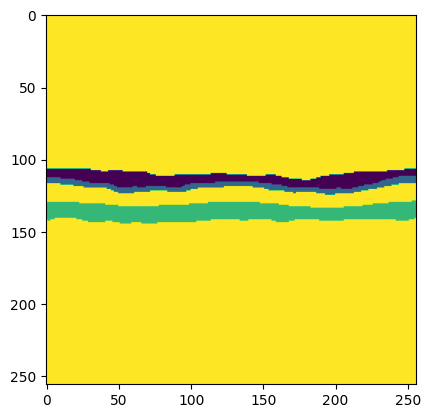

In [14]:
# Inference Step
# Validation data in test mode
val_data = OCTDataset(
    image_file=train_images_folder,
    gt_path=gt_folder,
    filelists=val_filelists,
    mode="test",
)

# load the model parameters
device = torch.device(DEVICE)
best_model = get_model(
    MODEL_NAME,
    in_channels=3,
    num_classes=4,
    out_channels=OUT_CHANNELS,
    mlp_dim=MLP_DIM,
    block_num=BLOCK_NUM,
    dropout_prob=DROPOUT_PROB,
    skip_prob=SKIP_PROB,
).to(device)

best_model_params_path = os.path.join(
    MODELS_PATH, f"{best_model.__class__.__name__}{AUGMENT_STRING}_best_params.pt"
)
best_model = load_model(best_model, best_model_params_path).to(device)
best_model.eval()


### The  images in the test dataset are segmented one by one
### The segmentation results are resized and stored as png images
for i, (img, idx, h, w) in enumerate(val_data):
    with torch.no_grad():
        img = img[np.newaxis, ...]
        img = torch.Tensor((img / 255.0).to(torch.float32)).to(device)
        logits = best_model(img)
        pred_img = logits.cpu().numpy().argmax(1)
        pred_gray = np.squeeze(pred_img, axis=0)
        pred_gray = pred_gray.astype("float32")
        pred_gray[pred_gray == 1] = 80
        pred_gray[pred_gray == 2] = 160
        pred_gray[pred_gray == 3] = 255
        pred_ = cv2.resize(pred_gray, (w, h))
        plt.subplots
        plt.imshow(pred_img.squeeze())
        cv2.imwrite(
            "validation/Layer_Segmentations/Layer_Segmentations/" + str(idx) + ".png", pred_
        )

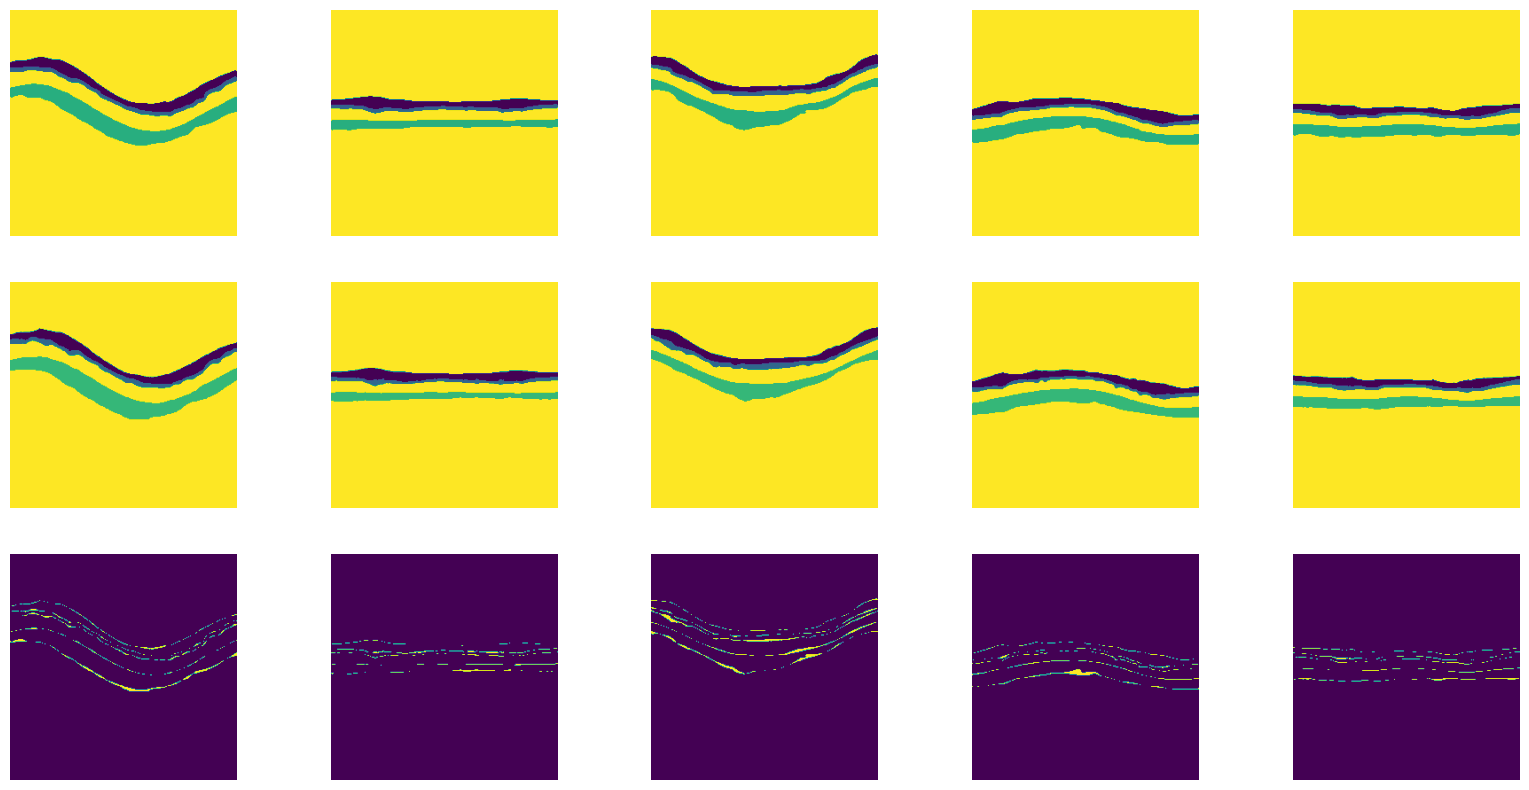

In [11]:
# # Inference Step
# # Validation data in test mode

# load the model parameters
device = torch.device(DEVICE)
best_model = get_model(
    MODEL_NAME,
    in_channels=3,
    num_classes=4,
    out_channels=OUT_CHANNELS,
    mlp_dim=MLP_DIM,
    block_num=BLOCK_NUM,
    dropout_prob=DROPOUT_PROB,
    skip_prob=SKIP_PROB,
).to(device)

best_model_params_path = os.path.join(
    MODELS_PATH, f"{best_model.__class__.__name__}{AUGMENT_STRING}_best_params.pt"
)
best_model = load_model(best_model, best_model_params_path).to(device)
best_model.eval()

### The  images in the test dataset are segmented one by one
### The segmentation results are resized and stored as png images
plt.figure(figsize=(20, 10))

imgs, masks = next(iter(val_loader))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    with torch.no_grad():
        img = img[np.newaxis, ...]
        img = torch.Tensor((img / 255.0)).to(torch.float32).to(device)
        logits = best_model(img)
        pred_img = logits.cpu().numpy().argmax(1)
        pred_gray = np.squeeze(pred_img, axis=0)
        pred_gray = pred_gray.astype("float32")
        pred_gray[pred_gray == 1] = 80
        pred_gray[pred_gray == 2] = 160
        pred_gray[pred_gray == 3] = 255

        plt.subplot(3, 5, i + 1)
        plt.imshow(pred_gray)
        plt.axis("off")

        plt.subplot(3, 5, i + 6)
        plt.imshow(mask)
        plt.axis("off")

        difference = pred_img != np.array(mask)

        plt.subplot(3, 5, i + 11)
        plt.imshow(difference.squeeze())
        plt.axis("off")

        if i == 4:
            break

## Validation


Best TransUNet loaded unstrictly at models/TransUNet_augment_best_params.pt


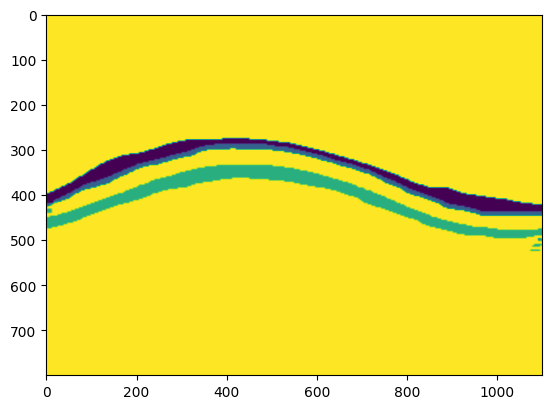

In [13]:
# Validation:

val_images_folder = (
    "/content/gdrive/MyDrive/AI4MI/val/Image" if COLAB else "data/val/Image"
)

val_filelists = [f for f in os.listdir(val_images_folder) if f.endswith(".png")]

val_data = OCTDataset(
    image_file=val_images_folder,
    gt_path=gt_folder,
    filelists=val_filelists,
    mode="test",
)

# load the model parameters
device = torch.device(DEVICE)
best_model = get_model(
    MODEL_NAME,
    in_channels=3,
    num_classes=4,
    out_channels=OUT_CHANNELS,
    mlp_dim=MLP_DIM,
    block_num=BLOCK_NUM,
    dropout_prob=DROPOUT_PROB,
    skip_prob=SKIP_PROB,
).to(device)

best_model_params_path = os.path.join(
    MODELS_PATH, f"{best_model.__class__.__name__}_{AUGMENT_STRING}_best_params.pt"
)
best_model = load_model(best_model, best_model_params_path).to(device)
best_model.eval()

### The  images in the test dataset are segmented one by one
### The segmentation results are resized and stored as png images
for i, (img, idx, h, w) in enumerate(val_data):
    with torch.no_grad():
        img = img[np.newaxis, ...]
        img = torch.Tensor((img / 255.0).to(torch.float32)).to(device)
        logits = best_model(img)
        pred_img = logits.cpu().numpy().argmax(1)
        pred_gray = np.squeeze(pred_img, axis=0)
        pred_gray = pred_gray.astype("float32")
        pred_gray[pred_gray == 1] = 80
        pred_gray[pred_gray == 2] = 160
        pred_gray[pred_gray == 3] = 255
        pred_ = cv2.resize(pred_gray, (w, h))
        plt.subplots
        plt.imshow(pred_)
        png_save = pred_.astype(np.uint8)
        if not cv2.imwrite(
            "validation/Layer_Segmentations/Layer_Segmentations" + idx, png_save
        ):
            raise Exception("Could not write image")

Compare number of params for models


In [19]:
# Number of parameters

for model_name in ["unet", "transunet", "transynet", "y_net_gen_ffc"]:
    model = get_model(
        model_name,
        in_channels=3,
        num_classes=4,
        out_channels=64,
        mlp_dim=1024,
        block_num=12,
    )

    print(
        f"{model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad == True)} params"
    )

UNet: 31043716 params
TransUNet: 31557396 params
TransYNet: 75392452 params
YNet_general: 27686404 params


Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions.
